In [1]:
#pip install numpy


In [2]:
#pip install pandas

In [3]:
#pip install seaborn

In [4]:
#pip install plotly

In [5]:
#pip install statsmodels

In [6]:
#pip install yfinance

In [7]:
#pip install scikit-learn

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
# Importa la función para crear la matriz de confusión
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')
df_jo = pm.df('df_jo')
#df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
#df_jo = df_jo.drop(columns=['index'])
#df_jo = df_jo.drop(columns=['Mes_created_at'])
#df_jo_cp = df_jo.copy()
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])
#df_jo.info()


In [9]:
pd.options.display.max_columns = None
pm.format_to_dates(df_jo, time_format='d') # 'min','s'
df = pm.df('df_hyper')
display(df)

,user_id,amount,needs_m_check_recov,n_fees,n_backs,n_recovery,n_incidents,transfer_type,charge_moment,n_cr_fe_w,category,inflation
0,47,1.0,1,0,0,0,1,regular,NaN,NaN,NaN,1.3
1,99001309,100.0,0,0,1,0,0,regular,NaN,1.0,NaN,1.3
2,804,100.0,1,0,0,0,1,regular,NaN,NaN,NaN,1.3
3,812,100.0,1,0,0,1,1,regular,NaN,NaN,NaN,1.3
4,191,100.0,1,0,0,0,1,regular,NaN,NaN,NaN,1.3
...,...,...,...,...,...,...,...,...,...,...,...,...
32087,55916,50.0,0,2,2,0,1,instant,after,1.0,nice,0.7
32088,39339,100.0,0,3,3,0,0,instant,after,1.0,nice,0.7
32089,24505,50.0,1,2,2,3,8,instant,NaN,NaN,NaN,0.7
32090,100781,60.0,0,1,1,0,0,instant,after,1.0,nice,0.7


In [10]:
#X_log_L=df_jo.drop(columns=['id_cr','id_fe','fe_cr_id','active','stat_cr','needs_m_check_recov','stat_fe','recovery_status','Mes_created_at','created_at_d','reason'])
X_log_L=df
y_log_L=df_jo['needs_m_check_recov']

In [11]:
X_log_L.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   user_id              32092 non-null  int64  
 1   amount               32092 non-null  float64
 2   needs_m_check_recov  32092 non-null  int64  
 3   n_fees               32092 non-null  int64  
 4   n_backs              32092 non-null  int64  
 5   n_recovery           32092 non-null  int64  
 6   n_incidents          32092 non-null  int64  
 7   transfer_type        32092 non-null  object 
 8   charge_moment        21055 non-null  object 
 9   n_cr_fe_w            23171 non-null  float64
 10  category             21055 non-null  object 
 11  inflation            32092 non-null  float64
dtypes: float64(3), int64(6), object(3)
memory usage: 2.9+ MB


In [12]:
# Convertir las columnas de tipo timedelta64
for col in X_log_L.select_dtypes(include=['timedelta64']).columns:
    X_log_L[col] = X_log_L[col].apply(lambda x: x / pd.to_timedelta(1, unit='d') if pd.notnull(x) else None)

In [13]:
# Convertir las columnas de tipo datetime64
for col in X_log_L.select_dtypes(include=['datetime64']).columns:
    X_log_L[col] = X_log_L[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)

In [14]:
# One Hot econding para pasar a numéricas todas las categóricas
X_log_L = pd.get_dummies(X_log_L, columns=['transfer_type'], drop_first=True, dtype=int)

In [15]:
X_log_L = pd.get_dummies(X_log_L, columns= ['charge_moment','category'], drop_first=True, dtype=int)

In [16]:
X_log_L = X_log_L.fillna(0)
X_log_L.isna().sum()

# Crear el escalador
display(X_log_L.head(1))
y = X_log_L['needs_m_check_recov'].copy()  #Segun moderated_at
X_log_L = X_log_L.drop(columns=['needs_m_check_recov'])
scaler = StandardScaler()
# Estandarizar todas las columnas
normalizado = scaler.fit_transform(X_log_L)
# Convertir de nuevo a DataFrame, preservando nombres de columnas e índices
X = pd.DataFrame(normalizado, columns=X_log_L.columns, index=df.index)
X.fillna(0, inplace=True)
#X.info()


,user_id,amount,needs_m_check_recov,n_fees,n_backs,n_recovery,n_incidents,n_cr_fe_w,inflation,transfer_type_regular,charge_moment_before,category_nice,category_rejected_direct_debit
0,47,1.0,1,0,0,0,1,0.0,1.3,1,0,0,0


In [17]:
# Aplicar Penalizaciones Ridge y Lasso para Regresion Lineal CON TODAS LAS COLUMNAS (calculadas y originales)

X=X_log_L
y= y_log_L

# X son las características y y es la variable objetivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos (importante para regularización)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo con penalización L1 (similar a Lasso)
logreg_l1 = LogisticRegression(penalty='l1', solver='saga', C=1.0, random_state=42) #probar tb con solver='liblinear'
logreg_l1.fit(X_train_scaled, y_train)

# Modelo con penalización L2 (similar a Ridge)
logreg_l2 = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, random_state=42)
logreg_l2.fit(X_train_scaled, y_train)

# Predicciones
y_pred_l1 = logreg_l1.predict(X_test_scaled)
y_pred_l2 = logreg_l2.predict(X_test_scaled)

# Evaluación (por ejemplo, exactitud)
from sklearn.metrics import accuracy_score
print("Exactitud L1 (LASSO):", accuracy_score(y_test, y_pred_l1))
print("Exactitud L2 (Ridge):", accuracy_score(y_test, y_pred_l2))


Exactitud L1 (LASSO): 0.8993612712260477
Exactitud L2 (Ridge): 0.8993612712260477


/home/cesc/tensorflow_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [18]:
# Extraer los coeficientes para la L1
coefs = logreg_l1.coef_[0]  # Para regresión logística binaria, es un vector 1D

# Crear un DataFrame para visualizar los coeficientes junto con las características
importancia = pd.DataFrame({
    'Característica': X_train.columns,
    'Coeficiente': coefs
})

# Ordenar por la magnitud de los coeficientes
importancia = importancia.reindex(importancia['Coeficiente'].abs().sort_values(ascending=False).index)

# Mostrar las características con coeficientes no nulos (para Lasso)
importancia_no_nula = importancia[importancia['Coeficiente'] != 0]

print("Características importantes para LASSO:")
print(importancia_no_nula)

Características importantes para LASSO:
                    Característica  Coeficiente
4                       n_recovery     2.989358
11  category_rejected_direct_debit     1.738150
5                      n_incidents     1.680133
3                          n_backs    -1.102812
6                        n_cr_fe_w    -0.922368
2                           n_fees    -0.894812
9             charge_moment_before     0.342336
1                           amount     0.324817
8            transfer_type_regular    -0.271376
7                        inflation    -0.214834
0                          user_id     0.191324
10                   category_nice     0.026170


In [19]:
# Extraer los coeficientes para la L2
coefs2 = logreg_l2.coef_[0]  # Para regresión logística binaria, es un vector 1D

# Crear un DataFrame para visualizar los coeficientes junto con las características
importancia2 = pd.DataFrame({
    'Característica': X_train.columns,
    'Coeficiente': coefs2
})

# Ordenar por la magnitud de los coeficientes
importancia2 = importancia2.reindex(importancia2['Coeficiente'].abs().sort_values(ascending=False).index)

# Mostrar las características con coeficientes no nulos (para Lasso)
importancia_no_nula2 = importancia2[importancia2['Coeficiente'] != 0]

print("Características importantes para RIDGE:")
print(importancia_no_nula2)

Características importantes para RIDGE:
                    Característica  Coeficiente
4                       n_recovery     2.977277
5                      n_incidents     1.681034
11  category_rejected_direct_debit     1.636971
3                          n_backs    -1.101348
6                        n_cr_fe_w    -0.921012
2                           n_fees    -0.894829
9             charge_moment_before     0.341964
1                           amount     0.324819
8            transfer_type_regular    -0.271566
7                        inflation    -0.214685
0                          user_id     0.191900
10                   category_nice     0.026753


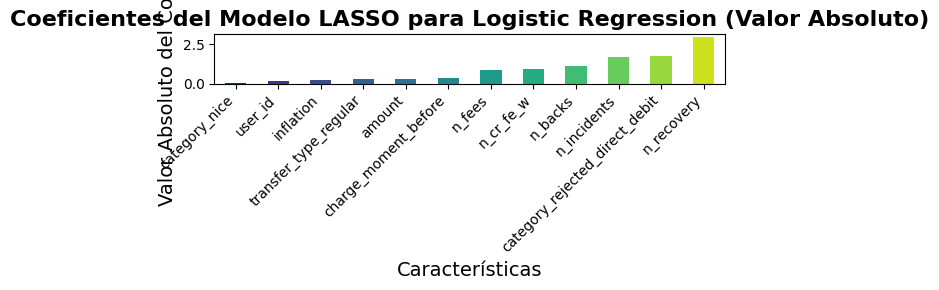

In [ ]:
# Graficamos los coeficientes ordenados por valor absoluto
plt.figure(figsize=(10, 6))

# Convertir 'coefs' a un pandas.Series
coefs_series = pd.Series(coefs, index=X_train.columns)

# Ordenar los coeficientes de menor a mayor (en valor absoluto)
coefs_series = coefs_series.abs().sort_values(ascending=True)

# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_series.plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_series)))

# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes del Modelo LASSO para Logistic Regression (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)
# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')
# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()

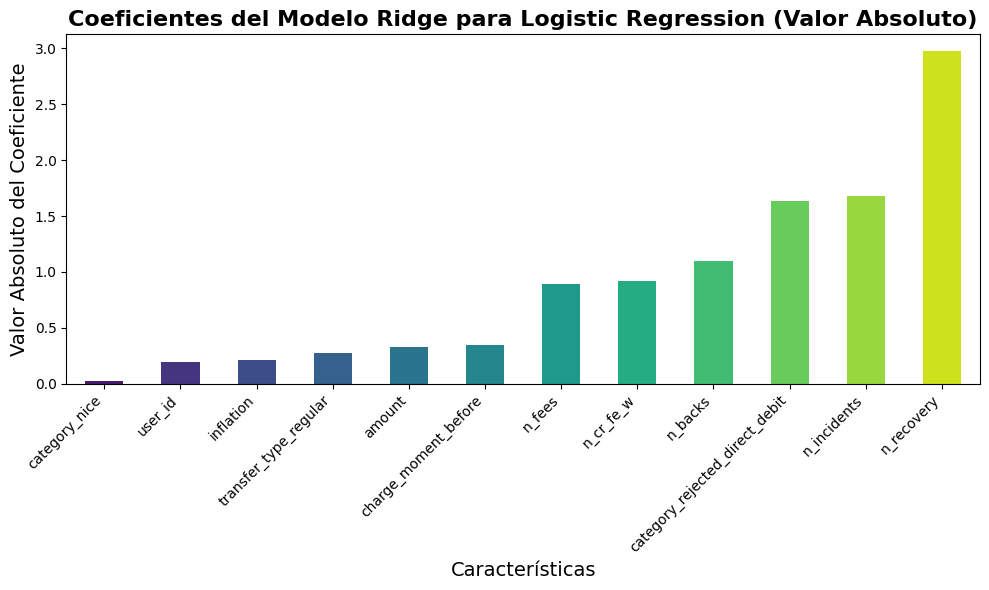

In [21]:
# Graficamos los coeficientes ordenados por valor absoluto
plt.figure(figsize=(10, 6))

# Convertir 'coefs' a un pandas.Series
coefs_series2 = pd.Series(coefs2, index=X_train.columns)

# Ordenar los coeficientes de menor a mayor (en valor absoluto)
coefs_series2 = coefs_series2.abs().sort_values(ascending=True)

# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_series2.plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_series)))

# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes del Modelo Ridge para Logistic Regression (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)
# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')
# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()

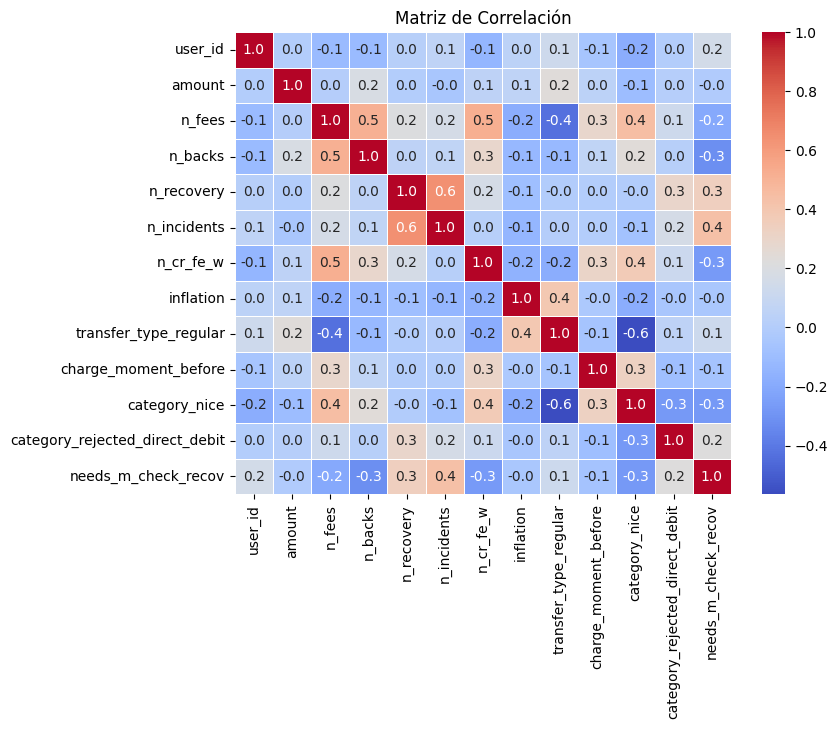

In [22]:
data_matriz= X_log_L
data_matriz['needs_m_check_recov']=y_log_L

# Calcular la matriz de correlación
matriz_correlacion = data_matriz.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(8,6))
sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm', fmt='.1f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

In [23]:
# plt.scatter(data_matriz['reimbursement_date'], data_matriz['created_at'])
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.title('Gráfico de dispersión entre Feature 1 y Feature 2')
# plt.show()

In [24]:
# plt.scatter(data_matriz['cash_request_received_date'], data_matriz['cr_received_date'])
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.title('Gráfico de dispersión entre Feature 1 y Feature 2')
# plt.show()

In [25]:
# plt.scatter(data_matriz['unemploy_rate'], data_matriz['n_fees'])
# plt.xlabel('Feature 1')
# plt.ylabel('Feature 2')
# plt.title('Gráfico de dispersión entre Feature 1 y Feature 2')
# plt.show()

In [26]:
# Sacar columnas altamente correlacionadas ['created_at_fe','reimbursememt_date','updated_at_fe','cash_request_received_date','from_date','to_date','category_nice','reco_last_update']
#data_matriz=data_matriz.drop(columns=['created_at_fe','reimbursement_date','updated_at_fe','cash_request_received_date','from_date','to_date','category_nice','reco_last_update','cr_received_date'])

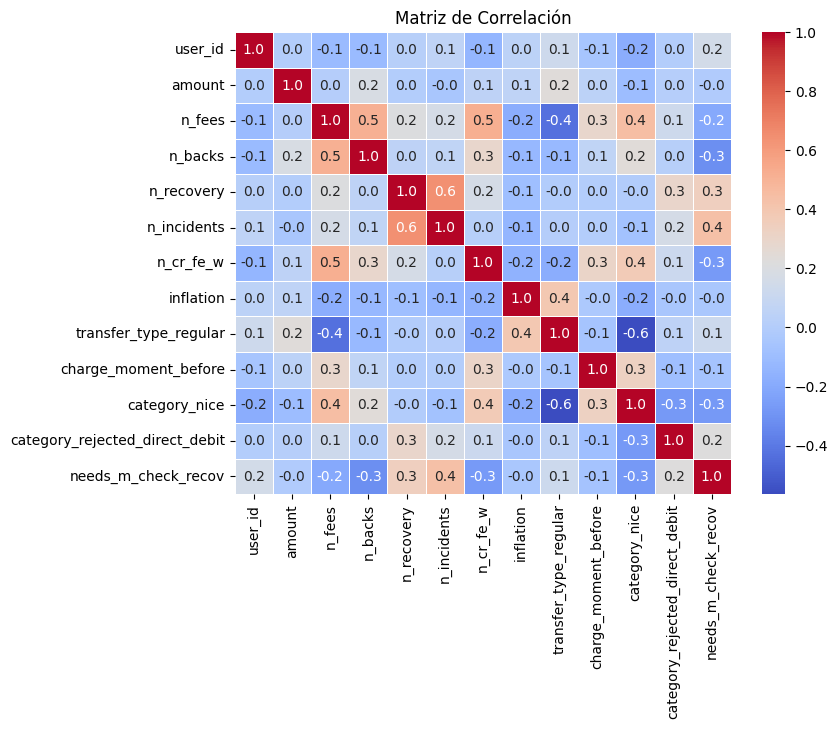

In [27]:
# Calcular la matriz de correlación
matriz_correlacion2 = data_matriz.corr()

# Visualizar la matriz de correlación
plt.figure(figsize=(8,6))
sns.heatmap(matriz_correlacion2, annot=True, cmap='coolwarm', fmt='.1f', linewidths=0.5)
plt.title('Matriz de Correlación')
plt.show()

In [ ]:
# Aplicar Penalizaciones Ridge y Lasso para Regresion Lineal CON LA SELECCIÓN para evitar correlaciones altas 

X=data_matriz.drop(columns=['needs_m_check_recov'])
y= data_matriz['needs_m_check_recov']

# X son las características y y es la variable objetivo
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Escalar los datos (importante para regularización)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Modelo con penalización L1 (similar a Lasso)
logreg_l1 = LogisticRegression(penalty='l1', solver='saga', C=1.0, random_state=42) #probar tb con solver='liblinear'
logreg_l1.fit(X_train_scaled, y_train)

# Modelo con penalización L2 (similar a Ridge)
logreg_l2 = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, random_state=42)
logreg_l2.fit(X_train_scaled, y_train)

# Predicciones
y_pred_l1 = logreg_l1.predict(X_test_scaled)
y_pred_l2 = logreg_l2.predict(X_test_scaled)

# Evaluación (por ejemplo, exactitud)
from sklearn.metrics import accuracy_score
print("Exactitud L1 (LASSO):", accuracy_score(y_test, y_pred_l1))
print("Exactitud L2 (Ridge):", accuracy_score(y_test, y_pred_l2))


/home/cesc/tensorflow_env/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Exactitud L1 (LASSO): 0.8993612712260477
Exactitud L2 (Ridge): 0.8993612712260477


In [29]:
# Extraer los coeficientes para la L1
coefs = logreg_l1.coef_[0]  # Para regresión logística binaria, es un vector 1D

# Crear un DataFrame para visualizar los coeficientes junto con las características
importancia = pd.DataFrame({
    'Característica': X_train.columns,
    'Coeficiente': coefs
})

# Ordenar por la magnitud de los coeficientes
importancia = importancia.reindex(importancia['Coeficiente'].abs().sort_values(ascending=False).index)

# Mostrar las características con coeficientes no nulos (para Lasso)
importancia_no_nula = importancia[importancia['Coeficiente'] != 0]

print("Características importantes para LASSO:")
print(importancia_no_nula)

Características importantes para LASSO:
                    Característica  Coeficiente
4                       n_recovery     2.989358
11  category_rejected_direct_debit     1.738150
5                      n_incidents     1.680133
3                          n_backs    -1.102812
6                        n_cr_fe_w    -0.922368
2                           n_fees    -0.894812
9             charge_moment_before     0.342336
1                           amount     0.324817
8            transfer_type_regular    -0.271376
7                        inflation    -0.214834
0                          user_id     0.191324
10                   category_nice     0.026170


In [30]:
# Extraer los coeficientes para la L2
coefs2 = logreg_l2.coef_[0]  # Para regresión logística binaria, es un vector 1D

# Crear un DataFrame para visualizar los coeficientes junto con las características
importancia2 = pd.DataFrame({
    'Característica': X_train.columns,
    'Coeficiente': coefs2
})

# Ordenar por la magnitud de los coeficientes
importancia2 = importancia2.reindex(importancia2['Coeficiente'].abs().sort_values(ascending=False).index)

# Mostrar las características con coeficientes no nulos (para Lasso)
importancia_no_nula2 = importancia2[importancia2['Coeficiente'] != 0]

print("Características importantes para RIDGE:")
print(importancia_no_nula2)

Características importantes para RIDGE:
                    Característica  Coeficiente
4                       n_recovery     2.977277
5                      n_incidents     1.681034
11  category_rejected_direct_debit     1.636971
3                          n_backs    -1.101348
6                        n_cr_fe_w    -0.921012
2                           n_fees    -0.894829
9             charge_moment_before     0.341964
1                           amount     0.324819
8            transfer_type_regular    -0.271566
7                        inflation    -0.214685
0                          user_id     0.191900
10                   category_nice     0.026753


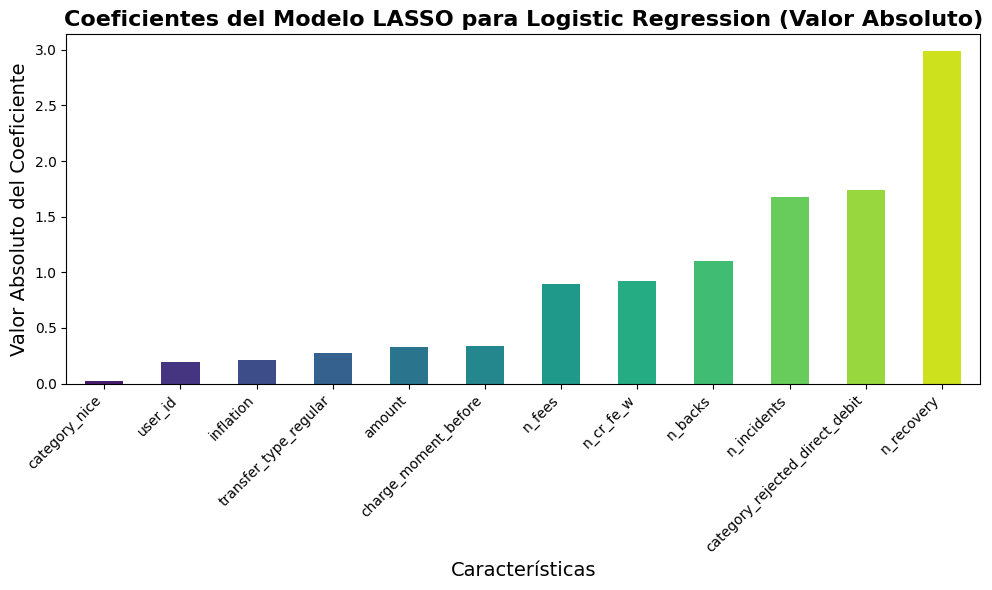

In [31]:
# Graficamos los coeficientes ordenados por valor absoluto
plt.figure(figsize=(10, 6))

# Convertir 'coefs' a un pandas.Series
coefs_series = pd.Series(coefs, index=X_train.columns)

# Ordenar los coeficientes de menor a mayor (en valor absoluto)
coefs_series = coefs_series.abs().sort_values(ascending=True)

# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_series.plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_series)))

# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes del Modelo LASSO para Logistic Regression (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)
# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')
# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()

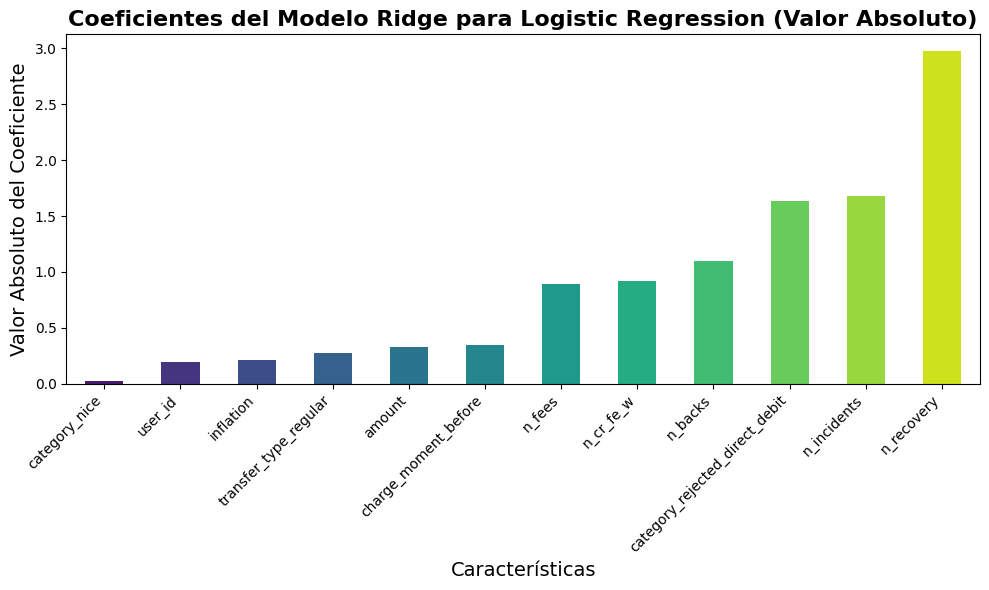

In [32]:
# Graficamos los coeficientes ordenados por valor absoluto
plt.figure(figsize=(10, 6))

# Convertir 'coefs' a un pandas.Series
coefs_series2 = pd.Series(coefs2, index=X_train.columns)

# Ordenar los coeficientes de menor a mayor (en valor absoluto)
coefs_series2 = coefs_series2.abs().sort_values(ascending=True)

# Ordenar los coeficientes de menor a mayor (invirtiendo el orden)
coefs_series2.plot(kind='bar', color=sns.color_palette("viridis", n_colors=len(coefs_series)))

# Añadimos el título y etiquetas a los ejes
plt.title('Coeficientes del Modelo Ridge para Logistic Regression (Valor Absoluto)', fontsize=16, weight='bold')
plt.xlabel('Características', fontsize=14)
plt.ylabel('Valor Absoluto del Coeficiente', fontsize=14)
# Ajustamos las etiquetas del eje x para mejorar la legibilidad
plt.xticks(rotation=45, ha='right')
# Mostramos la gráfica con un diseño ajustado
plt.tight_layout() # Ajuste del espaciado para evitar solapamientos
plt.show()

In [33]:
# Probamos MODELO REGRESION LOGISTICA con las columnas más significativas (7 primeras por ejemplo)

X= data_matriz[['n_recovery','paid_at','type_postpone','money_back_date','fee','charge_moment_before','unemploy_rate']]
y=data_matriz['needs_m_check_recov']

# Obtener los nombres de las características
feature_names = X.columns

# Divide los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

# Crea el clasificador de regresión logística. El 'liblinear' usa metodo de optimización de minimos cuadrados generalizados (L2) y soporta la regularización L1 y L2
clf = LogisticRegression(solver="liblinear")

# Entrena el clasificador
clf.fit(X_train, y_train)

# Realiza predicciones sobre el conjunto de prueba
predicciones = clf.predict(X_test)

# Genera las probabilidades de predicción
predicciones_probabilidades = clf.predict_proba(X_test)

# Muestra las primeras 10 probabilidades de predicción
#predicciones_probabilidades[:10]

# Obtén los coeficientes y asigna los nombres de las características
coeficientes = clf.coef_[0]  # clf.coef_ es un array bidimensional, tomamos la primera fila
feature_coef = list(zip(feature_names, coeficientes))

# Ordena las características por el valor absoluto del coeficiente en orden descendente
feature_coef_sorted = sorted(feature_coef, key=lambda x: abs(x[1]), reverse=True)

# Imprime cada variable junto con su coeficiente ordenado
print("Coeficientes del modelo de regresión logística (ordenados por magnitud):")
for feature, coef in feature_coef_sorted:
    print(f"{feature}: {coef:.8f}")
    
# Crea un histograma de las probabilidades de predicción para ambas clases
plt.figure(figsize=(10, 6)) 

# # Histograma para la clase negativa (need manual check)
plt.hist(predicciones_probabilidades[:, 0], bins=20, color="skyblue", edgecolor="black", alpha=0.3, label="Necesita Manual check")
# Histograma para la clase positiva (no need manual check)
plt.hist(predicciones_probabilidades[:, 1], bins=20, color="salmon", edgecolor="black", alpha=0.3, label="No necesita Manual check")
# Título y etiquetas de los ejes
plt.title("Distribución de Probabilidades de Predicción para Ambas Clases")
plt.xlabel("Probabilidad de Predicción")
plt.ylabel("Frecuencia")
plt.legend(loc="upper center") 
# Muestra la leyenda en el gráfico
plt.grid(axis="y", linestyle="--", alpha=0.1)
plt.show()

# Evaluate model performance
print("Accuracy:", clf.score(X_test, y_test))  # Accuracy score
print("Classification Report:\n", classification_report(y_test, predicciones))  # Classification report

# Genera la matriz de confusión
matriz_confusion = confusion_matrix(y_test, predicciones)
columnas = ['no_needs_m_check', 'needs_m_check'] # 0 para No necesita manual check y 1 para Sí necesita manual check

# Visualiza la matriz de confusión utilizando un mapa de calor

plt.figure(figsize=(8, 6))
sns.heatmap(matriz_confusion, annot=True, fmt='d', cmap='Blues', xticklabels=columnas, yticklabels=columnas)
plt.xlabel("Predicción")
plt.ylabel("Realidad")

KeyError: "['paid_at', 'type_postpone', 'money_back_date', 'fee', 'unemploy_rate'] not in index"